### Table of Content
##### [1.Loading Data](#loaddata)

[1.1Transaction Data](#transc_data)

[1.2Memeber Data](#memb_data)

[1.3User Logs](#user_log)

[2.Feature Engineering](#feature)

[3.Simple Modeling](#simplemodel)

[4.Ensemble Modeling](#ensmbmodel)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print ("read training set, test set")
train = pd.read_csv('data/train_v2.csv').set_index('msno')
test = pd.read_csv('data/sample_submission_v2.csv').set_index('msno')
test['is_churn'] = np.nan

read training set, test set


In [3]:
print ("read trasaction set, test set")
transc1 = pd.read_csv('data/transactions.csv',parse_dates=['transaction_date','membership_expire_date']).set_index('msno')
transc2 = pd.read_csv('data/transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date']).set_index('msno')
transc = pd.concat([transc1,transc2],axis=0,ignore_index=False)
print ('total transaction entities {:d}'.format(transc.shape[0]))
print ('columns name')
print (transc.columns)

read trasaction set, test set
total transaction entities 22978755
columns name
Index(['payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')


In [4]:
def add_transaction_count(data,transc):
    print ('adding_transaction_count...')
    temp = (transc1['transaction_date'].reset_index().groupby('msno').count()
            .rename(index=str,columns={'transaction_date':'transc_counts'}))
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')
    return data
def add_last_transc_days_from_now(data,transc,end_date):
    print ('adding_last_transc_days_from_now...')
    temp = (transc['transaction_date'].reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='last').set_index('msno')
            .rename(index=str,columns={'transaction_date':'latest_transc_date'}))
    temp['end_date'] = end_date
    temp['days_since_last_transc'] = (temp.end_date-temp.latest_transc_date).dt.days
    data = pd.merge(data,temp['days_since_last_transc'].to_frame(),left_index=True,right_index=True,how='left')
    return data
def add_first_transc_days_from_now(data,transc,end_date):
    print ('adding_first_transc_days_from_now...')
    temp = (transc['transaction_date'].reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='first').set_index('msno')
            .rename(index=str,columns={'transaction_date':'first_transc_date'}))
    temp['end_date'] = end_date
    temp['days_since_first_transc'] = (temp.end_date-temp.first_transc_date).dt.days
    data = pd.merge(data,temp['days_since_first_transc'].to_frame(),left_index=True,right_index=True,how='left')    
    return data
def add_member_expire_days_from_now(data,transc,end_date):
    print ('adding_member_expire_from_now...')
    temp = (transc['membership_expire_date'].reset_index().sort_values('membership_expire_date')
            .drop_duplicates('msno',keep='last').set_index('msno'))
    temp['end_date'] = end_date
    temp['days_till_member_expire'] = (temp.membership_expire_date-temp.end_date).dt.days
    data = pd.merge(data,temp['days_till_member_expire'].to_frame(),left_index=True,right_index=True,how='left')  
    return data
def add_latest_transaction_features(data,transc):
    print ('adding_transaction_features...')
    temp = (transc.reset_index().sort_values('transaction_date')
            .drop_duplicates('msno',keep='last').set_index('msno'))
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')  
    data = data.drop(columns=['membership_expire_date','transaction_date'])
    return data

In [5]:
from datetime import datetime
train_end = datetime(year=2017,month=2,day=28)
test_end = datetime(year=2017,month=3,day=31)
print ('merge trainsaction data...')
data = [train,test]
trans = [transc1,transc]
end_date = [train_end,test_end]
for i in range(2):
    data[i] = add_member_expire_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_transaction_count(data[i],trans[i])
    data[i] = add_last_transc_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_first_transc_days_from_now(data[i],trans[i],end_date[i])
    data[i] = add_latest_transaction_features(data[i],trans[i])

merge trainsaction data...
adding_member_expire_from_now...
adding_transaction_count...
adding_last_transc_days_from_now...
adding_first_transc_days_from_now...
adding_transaction_features...
adding_member_expire_from_now...
adding_transaction_count...
adding_last_transc_days_from_now...
adding_first_transc_days_from_now...
adding_transaction_features...


In [6]:
train_data = data[0].dropna()
test_data = data[0].dropna()

### Load Member data

In [7]:
member = pd.read_csv('data/members_v3.csv',parse_dates=['registration_init_time'])
all_member = pd.concat([train,test],axis=0).reset_index().drop_duplicates('msno').drop(columns=['is_churn'])
all_member = pd.merge(all_member,member,on='msno',how='left').set_index('msno')
print ("total member data entities {:d}".format(all_member.shape[0]))
print (all_member.columns)
print (all_member.isnull().sum())

total member data entities 1076941
Index(['city', 'bd', 'gender', 'registered_via', 'registration_init_time'], dtype='object')
city                      120376
bd                        120376
gender                    641415
registered_via            120376
registration_init_time    120376
dtype: int64


In [8]:
#filling missing value
all_member.loc[(all_member.bd>100) | (all_member.bd<0) | all_member.bd.isnull(),'bd'] = 0
all_member.loc[all_member.city.isnull(),'city'] = all_member.city.value_counts().index[0]
all_member.loc[all_member.registered_via.isnull(),'registered_via'] = all_member.registered_via.value_counts().index[0]
all_member.loc[all_member.gender.isnull(),'gender']='unknow'
all_member = all_member.drop(columns=['registration_init_time'])

In [9]:
train_data = pd.merge(train_data,all_member,right_index=True,left_index=True,how='left')
test_data = pd.merge(test_data,all_member,right_index=True,left_index=True,how='left')

In [10]:
train_data.head()

,is_churn,days_till_member_expire,transc_counts,days_since_last_transc,days_since_first_transc,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,registered_via
msno,,,,,,,,,,,,,,,
ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,30.0,6.0,0.0,700.0,38.0,30.0,149.0,149.0,0.0,0.0,5.0,28.0,male,3.0
f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,12.0,5.0,18.0,362.0,36.0,30.0,180.0,180.0,0.0,0.0,13.0,20.0,male,3.0
zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,7.0,18.0,29.0,559.0,38.0,30.0,149.0,149.0,0.0,0.0,13.0,18.0,male,3.0
8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,8.0,19.0,369.0,782.0,35.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,unknow,7.0
K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,5.0,24.0,180.0,766.0,41.0,30.0,99.0,99.0,1.0,0.0,13.0,35.0,female,7.0


### User Logs

In [13]:
from datetime import datetime
train_end = datetime(year=2017,month=2,day=28)
test_end = datetime(year=2017,month=3,day=31)
users_msno = list(all_member.index)
user_logs2 = pd.read_csv('data/user_logs_v2.csv',parse_dates=['date'])

In [ ]:
def read_log_chunk(path,chunksize=chunksize,period=[train_start,train_end],users_msno=users_msno):
    import time
    reader = pd.read_csv(path,parse_dates=['date'], iterator=True)
    i = 0
    n_total = 0
    chunks = []
    loop = True
    start = time.time()
    while loop:
        try:
            i+=1
            print ('===reading {:d}th chunks==='.format(i))
            chunk = reader.get_chunk(chunksize)
            #date filter
            ma1 = ((chunk.date>train_start)&(chunk.date<train_end))
            if ma1.sum()>0:
                chunk = chunk.loc[ma1,:]
                #msno filter
                ma2 = chunk.msno.isin(users_msno)
                if ma2.sum()>0:
                    n_total += ma2.sum()
                    print ('chunk data read = {:d}'.format(ma2.sum()))
                    chunk = chunk.loc[ma2,:]
                    chunks.append(chunk)
                else:pass
            else:pass
            dt = time.time()-start
            print ('total data read = {:d}'.format(n_total))
            print ('time escape {:f}'.format(dt))
        except StopIteration:
            loop = False
            print ("Iteration is stopped.")
    user_log1 = pd.concat(chunks, ignore_index=True) 
    return user_logs1
user_logs1 = read_log_chunk

In [42]:
import time
train_end = datetime(year=2017,month=2,day=28)
train_start = datetime(year=2017,month=1,day=28)
chunksize=10000000
reader = pd.read_csv('data/user_logs.csv',parse_dates=['date'], iterator=True)
i = 0
n_total = 0
chunks = []
loop = True
start = time.time()
while loop:
    try:
        i+=1
        print ('===reading {:d}th chunks==='.format(i))
        chunk = reader.get_chunk(chunksize)
        #date filter
        ma1 = ((chunk.date>train_start)&(chunk.date<train_end))
        if ma1.sum()>0:
            chunk = chunk.loc[ma1,:]
            #msno filter
            ma2 = chunk.msno.isin(users_msno)
            if ma2.sum()>0:
                n_total += ma2.sum()
                print ('chunk data read = {:d}'.format(ma2.sum()))
                chunk = chunk.loc[ma2,:]
                chunks.append(chunk)
            else:pass
        else:pass
        dt = time.time()-start
        print ('total data read = {:d}'.format(n_total))
        print ('time escape {:f}'.format(dt))
    except StopIteration:
        loop = False
        print ("Iteration is stopped.")        

===reading 1th chunks===
chunk data read = 348239
total data read = 348239
time escape 14.809387
===reading 2th chunks===
chunk data read = 348050
total data read = 696289
time escape 29.534351
===reading 3th chunks===
chunk data read = 346888
total data read = 1043177
time escape 44.337697
===reading 4th chunks===
chunk data read = 347672
total data read = 1390849
time escape 59.045030
===reading 5th chunks===
chunk data read = 347783
total data read = 1738632
time escape 73.698718
===reading 6th chunks===
chunk data read = 347488
total data read = 2086120
time escape 89.023345
===reading 7th chunks===
chunk data read = 347233
total data read = 2433353
time escape 103.842318
===reading 8th chunks===
chunk data read = 347466
total data read = 2780819
time escape 118.688175
===reading 9th chunks===
chunk data read = 346872
total data read = 3127691
time escape 133.412735
===reading 10th chunks===
chunk data read = 347176
total data read = 3474867
time escape 148.394874
===reading 11th c

In [43]:
user_log1 = pd.concat(chunks, ignore_index=True) 

In [68]:
def add_user_stats_feature(data,user_logs):
    temp = (user_logs.groupby('msno').agg({'date':'count',
                                           'num_25':['max','median','sum'],
                                           'num_50':['max','median','sum'],
                                           'num_985':['max','median','sum'],
                                           'num_100':['max','median','sum'],
                                           'num_unq':['max','median','sum'],
                                           'total_secs':['max','median','sum']}))
    temp.columns = ["_".join(x) for x in temp.columns.ravel()]
    data = pd.merge(data,temp,left_index=True,right_index=True,how='left')
    data = data.drop(columns=['is_churn'])
    data = data.fillna(0)
    return data
data = [train,test]
user_log = [user_log1,user_logs2]
for i in range(2):
    data[i] = add_user_stats_feature(data[i],user_log[i])

In [70]:
train_data = pd.merge(train_data,data[0],right_index=True,left_index=True,how='left')
test_data = pd.merge(test_data,data[1],right_index=True,left_index=True,how='left')

In [77]:
train_data.columns

Index(['is_churn_x', 'days_till_member_expire', 'transc_counts',
       'days_since_last_transc', 'days_since_first_transc',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'city', 'bd',
       'gender', 'registered_via', 'is_churn_y', 'date_count', 'num_25_max',
       'num_25_median', 'num_25_sum', 'num_50_max', 'num_50_median',
       'num_50_sum', 'num_985_max', 'num_985_median', 'num_985_sum',
       'num_100_max', 'num_100_median', 'num_100_sum', 'num_unq_max',
       'num_unq_median', 'num_unq_sum', 'total_secs_max', 'total_secs_median',
       'total_secs_sum'],
      dtype='object')

In [106]:
train_data.shape

(968433, 41)

In [78]:
print (train_data.isnull().sum())
print (test_data.isnull().sum())

is_churn_x                      0
days_till_member_expire         0
transc_counts                   0
days_since_last_transc          0
days_since_first_transc         0
payment_method_id               0
payment_plan_days               0
plan_list_price                 0
actual_amount_paid              0
is_auto_renew                   0
is_cancel                       0
city                            0
bd                              0
gender                          0
registered_via                  0
is_churn_y                      0
date_count                 210558
num_25_max                 210558
num_25_median              210558
num_25_sum                 210558
num_50_max                 210558
num_50_median              210558
num_50_sum                 210558
num_985_max                210558
num_985_median             210558
num_985_sum                210558
num_100_max                210558
num_100_median             210558
num_100_sum                210558
num_unq_max   

In [79]:
train_data = train_data.drop(columns=['is_churn_y'])
test_date = test_data.drop(columns=['is_churn_y'])

In [80]:
train_data.fillna(value=0,inplace=True)
test_data.fillna(value=0,inplace=True)

In [102]:
train_data.reset_index().to_csv('training_feature_v2.csv',index=False)
test_data.reset_index().to_csv('testing_feature_v2.csv',index=False)

### Encodeing

In [87]:
corr_matrix = train_data.corr()

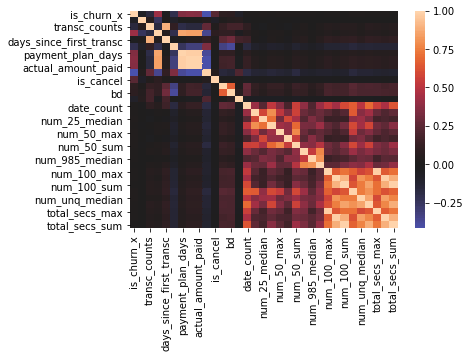

In [88]:
sns.heatmap(corr_matrix,center=0)

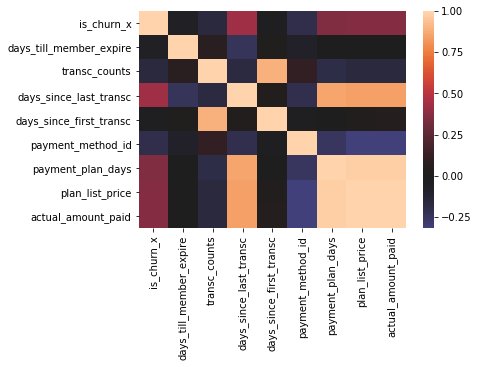

In [91]:
sns.heatmap(corr_matrix.iloc[:9,:9],center=0)

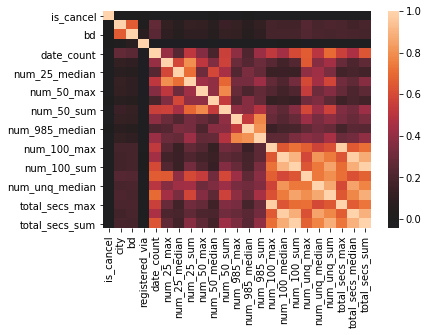

In [92]:
sns.heatmap(corr_matrix.iloc[10:,10:],center=0)

In [99]:
train_data = pd.read_csv('training_feature_v2.csv')
test_data  = pd.read_csv('testing_feature_v2.csv')

In [104]:
from sklearn.preprocessing import LabelEncoder
catagory = ['payment_method_id', 'payment_plan_days', 'plan_list_price','actual_amount_paid', 'city','gender', 'registered_via']
encoder = {}
for c in catagory:
    print (c)
    le = LabelEncoder()
    le.fit(pd.concat([train_data[c],test_data[c]],axis=0))
    name = c+'_encoded'
    train_data[name]= le.transform(train_data.loc[:,c])
    test_data[name]= le.transform(train_data.loc[:,c])
    encoder[c] = le

payment_method_id
payment_plan_days
plan_list_price
actual_amount_paid
city
gender
registered_via


#### Random Forest

In [129]:
X = train_data.drop(columns=catagory)
Y = test_data.drop(columns=catagory)
X = X.iloc[:,1:].values
Y = Y.iloc[:,0].values

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0,shuffle=True)

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit, KFold

kfold = ShuffleSplit(n_splits=10, test_size=0.25)
RF_clf = RandomForestClassifier(n_estimators=300,
                                max_features='sqrt',
                                max_depth=10,
                                bootstrap=True,
                                oob_score=True,
                                random_state=2)
cv = cross_val_score(RF_clf, X_train, y = y_train, scoring = "neg_log_loss", cv = kfold, n_jobs=-1, verbose=5)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ..................... , score=-0.17411235834026573, total=16.8min
[CV] ...................... , score=-0.1725068830843563, total=16.7min
[CV] ..................... , score=-0.17179927683659793, total=16.9min
[CV] ..................... , score=-0.17267442516950274, total=16.9min


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 16.9min remaining: 25.4min


[CV] ...................... , score=-0.1742056984779242, total=16.9min
[CV] ..................... , score=-0.17314725586801297, total=16.9min
[CV] ..................... , score=-0.17373618844132088, total=16.9min


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 17.0min remaining:  7.3min


[CV] ..................... , score=-0.17343725622749875, total=17.2min
[CV] ..................... , score=-0.17484311840612715, total=17.3min
[CV] ..................... , score=-0.17394566082332621, total=17.4min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.4min finished


In [133]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
n_iter_search = 60
kfold = ShuffleSplit(n_splits=3, test_size=0.25)
RF_rscv = RandomForestClassifier()
param_dist = {"n_estimators" : sp_randint(100, 1000),
              "max_depth": sp_randint(3, 50),
              "max_features": sp_randint(5, 50),
              "min_samples_split": sp_randint(2, 50),
              "min_samples_leaf": sp_randint(1, 50),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              'class_weight':[None,'balanced_subsample']}
random_search = RandomizedSearchCV(RF_rscv,
                                   param_distributions=param_dist,
                                   cv=kfold,
                                   scoring='neg_log_loss',
                                   n_iter=n_iter_search,
                                   random_state=0,
                                   n_jobs=-1,
                                   verbose=3)

start = time.time()
random_search.fit(X_train, y=y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=4, min_samples_split=41, n_estimators=109 
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=4, min_samples_split=41, n_estimators=109 
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=4, min_samples_split=41, n_estimators=109 
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=39, max_features=28, min_samples_leaf=7, min_samples_split=26, n_estimators=700 
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=39, max_features=28, min_samples_leaf=7, min_samples_split=26, n_estimators=700 
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=39, max_features=28, min_samples_leaf=7, min_samples_split=26, n_estimators=700 
[C

[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=14, max_features=33, min_samples_leaf=35, min_samples_split=2, n_estimators=228, score=-0.31010242789096293, total=73.0min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=3, max_features=41, min_samples_leaf=35, min_samples_split=31, n_estimators=487 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=14, max_features=33, min_samples_leaf=35, min_samples_split=2, n_estimators=228, score=-0.31142280077068824, total=74.3min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=3, max_features=41, min_samples_leaf=35, min_samples_split=31, n_estimators=487 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=14, max_features=33, min_samples_leaf=35, min_samples_split=2, n_estimators=228, score=-0.3113229367085251, total=74.6min
[CV] bootstrap=True, class_weight=None, criterion=gini, ma

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x2b69e2237300, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/yhh281/anaconda2/envs/pydata/lib/python3.6...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/yhh281.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x2b69e2237300, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/yhh281/anaconda2/envs/pydata/lib/python3.6...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/yhh281.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 12, 4, 43, 57, 846187, tzinfo=tzutc()), 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'session': 'E5DC8A301D2B43369A40A4C52AFB6F14', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'E5DC8A301D2B43369A40A4C52AFB6F14']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 12, 4, 43, 57, 846187, tzinfo=tzutc()), 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'session': 'E5DC8A301D2B43369A40A4C52AFB6F14', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'E5DC8A301D2B43369A40A4C52AFB6F14'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 12, 4, 43, 57, 846187, tzinfo=tzutc()), 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'session': 'E5DC8A301D2B43369A40A4C52AFB6F14', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '570EA53294654752869928D2DE1C40B4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from scipy.stats import randint as sp_randint\nfr...n_iter_search))\nreport(random_search.cv_results_)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-133-e57ad1aa7b4c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2b6c1ffa5630, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x2b6cf3581f60, file "<ipython-input-133-e57ad1aa7b4c>", line 24>
        result = <ExecutionResult object at 2b6c1ffa5630, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x2b6cf3581f60, file "<ipython-input-133-e57ad1aa7b4c>", line 24>, result=<ExecutionResult object at 2b6c1ffa5630, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x2b6cf3581f60, file "<ipython-input-133-e57ad1aa7b4c>", line 24>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...rt seaborn as sns\nimport matplotlib.pyplot as plt", 'print ("read training set, test set")\ntrain = pd...csv\').set_index(\'msno\')\ntest[\'is_churn\'] = np.nan', 'print ("read trasaction set, test set")\ntransc1 ...]))\nprint (\'columns name\')\nprint (transc.columns)', "def add_transaction_count(data,transc):\n    prin...expire_date','transaction_date'])\n    return data", 'from datetime import datetime\ntrain_end = dateti...add_latest_transaction_features(data[i],trans[i])', 'train_data = data[0].dropna()\ntest_data = data[0].dropna()', "member = pd.read_csv('data/members_v3.csv',parse...member.columns)\nprint (all_member.isnull().sum())", "#filling missing value\nall_member.loc[(all_membe...l_member.drop(columns=['registration_init_time'])", "train_data = pd.merge(train_data,all_member,righ...mber,right_index=True,left_index=True,how='left')", 'train_data.head()', 'from multiprocessing import Pool,cpu_count\ncpu_count()', "chunksize=10000000\ndfs = pd.read_csv('data/user_...memory=False, iterator=True, chunksize=chunksize)", "from datetime import datetime\ntrain_end = dateti...csv('data/user_logs_v2.csv',parse_dates=['date'])", 'i = 0\nchunks = []\nfor df in dfs:\n    if i<3:\n   ...r_log1 = pd.concat(chunks, ignore_index=True)    ', 'i = 0\nchunks = []\nloop = True\nwhile loop:\n    tr...r_log1 = pd.concat(chunks, ignore_index=True)    ', "chunksize=10000000\ndfs = pd.read_csv('data/user_...r_log1 = pd.concat(chunks, ignore_index=True)    ", "chunksize=10000000\ndfs = pd.read_csv('data/user_...r_log1 = pd.concat(chunks, ignore_index=True)    ", "import time\nchunksize=100000\ndfs = pd.read_csv('...r_log1 = pd.concat(chunks, ignore_index=True)    ", "import time\nchunksize=100000\ndfs = pd.read_csv('...r_log1 = pd.concat(chunks, ignore_index=True)    ", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {10:                                               is...pMgrEMdG2edFOxnA=  35.0  female             7.0  , 11: 20, 28:                                            msno ...       0        1      112       93   28401.558  , 29:                                                 ...    18    6309.273  

[18396362 rows x 9 columns], 30:                                                 ...       4        2        5       22    2566.144  , 39:                                            msno ...       0        0        8        8    1739.728  , 44: (13626921, 9), 48:                                            msno ...       0        0        8        8    1739.728  , 49: msno
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o...0=    14
Name: date, Length: 817999, dtype: int64, 50:                                    0            ...     std    4667.655883   4582.033646   -1.868651, ...}, 'Pool': <bound method BaseContext.Pool of <multiprocessing.context.DefaultContext object>>, 'RF_clf': RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=2, verbose=0, warm_start=False), 'RF_rscv': RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...rt seaborn as sns\nimport matplotlib.pyplot as plt", 'print ("read training set, test set")\ntrain = pd...csv\').set_index(\'msno\')\ntest[\'is_churn\'] = np.nan', 'print ("read trasaction set, test set")\ntransc1 ...]))\nprint (\'columns name\')\nprint (transc.columns)', "def add_transaction_count(data,transc):\n    prin...expire_date','transaction_date'])\n    return data", 'from datetime import datetime\ntrain_end = dateti...add_latest_transaction_features(data[i],trans[i])', 'train_data = data[0].dropna()\ntest_data = data[0].dropna()', "member = pd.read_csv('data/members_v3.csv',parse...member.columns)\nprint (all_member.isnull().sum())", "#filling missing value\nall_member.loc[(all_membe...l_member.drop(columns=['registration_init_time'])", "train_data = pd.merge(train_data,all_member,righ...mber,right_index=True,left_index=True,how='left')", 'train_data.head()', 'from multiprocessing import Pool,cpu_count\ncpu_count()', "chunksize=10000000\ndfs = pd.read_csv('data/user_...memory=False, iterator=True, chunksize=chunksize)", "from datetime import datetime\ntrain_end = dateti...csv('data/user_logs_v2.csv',parse_dates=['date'])", 'i = 0\nchunks = []\nfor df in dfs:\n    if i<3:\n   ...r_log1 = pd.concat(chunks, ignore_index=True)    ', 'i = 0\nchunks = []\nloop = True\nwhile loop:\n    tr...r_log1 = pd.concat(chunks, ignore_index=True)    ', "chunksize=10000000\ndfs = pd.read_csv('data/user_...r_log1 = pd.concat(chunks, ignore_index=True)    ", "chunksize=10000000\ndfs = pd.read_csv('data/user_...r_log1 = pd.concat(chunks, ignore_index=True)    ", "import time\nchunksize=100000\ndfs = pd.read_csv('...r_log1 = pd.concat(chunks, ignore_index=True)    ", "import time\nchunksize=100000\ndfs = pd.read_csv('...r_log1 = pd.concat(chunks, ignore_index=True)    ", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {10:                                               is...pMgrEMdG2edFOxnA=  35.0  female             7.0  , 11: 20, 28:                                            msno ...       0        1      112       93   28401.558  , 29:                                                 ...    18    6309.273  

[18396362 rows x 9 columns], 30:                                                 ...       4        2        5       22    2566.144  , 39:                                            msno ...       0        0        8        8    1739.728  , 44: (13626921, 9), 48:                                            msno ...       0        0        8        8    1739.728  , 49: msno
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o...0=    14
Name: date, Length: 817999, dtype: int64, 50:                                    0            ...     std    4667.655883   4582.033646   -1.868651, ...}, 'Pool': <bound method BaseContext.Pool of <multiprocessing.context.DefaultContext object>>, 'RF_clf': RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=2, verbose=0, warm_start=False), 'RF_rscv': RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/scratch/yhh281/DataScience/Kaggle_KKBox_Churn/<ipython-input-133-e57ad1aa7b4c> in <module>()
     19                                    random_state=0,
     20                                    n_jobs=-1,
     21                                    verbose=3)
     22 
     23 start = time.time()
---> 24 random_search.fit(X_train, y=y_train)
     25 print("RandomizedSearchCV took %.2f seconds for %d candidates"
     26       " parameter settings." % ((time.time() - start), n_iter_search))
     27 report(random_search.cv_results_)

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=RandomizedSearchCV(cv=ShuffleSplit(n_splits=3, r..._score='warn', scoring='neg_log_loss', verbose=3), X=array([[ 2., 19., 26., ...,  0.,  2.,  2.],
    ...2.],
       [ 4., 12., 24., ...,  0.,  2.,  2.]]), y=array([0, 0, 0, ..., 0, 0, 0]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method BaseShuffleSplit.split of ShuffleS...dom_state=None, test_size=0.25, train_size=None)>
        X = array([[ 2., 19., 26., ...,  0.,  2.,  2.],
    ...2.],
       [ 4., 12., 24., ...,  0.,  2.,  2.]])
        y = array([0, 0, 0, ..., 0, 0, 0])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Mar 12 00:44:10 2018
PID: 44978      Python 3.6.4: /home/yhh281/anaconda2/envs/pydata/bin/python
...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[ 2., 19., 26., ...,  0.,  2.,  2.],
   ....],
        [ 4., 12., 24., ...,  0.,  2.,  2.]]), memmap([0, 0, 0, ..., 0, 0, 0]), {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, memmap([156583, 335943, 555992, ...,  53636, 506549,  60936]), memmap([305015,  19597, 453879, ...,  23418, 693111, 646235]), 3, {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 43, 'min_samples_leaf': 40, 'min_samples_split': 25, 'n_estimators': 274}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[ 2., 19., 26., ...,  0.,  2.,  2.],
   ....],
        [ 4., 12., 24., ...,  0.,  2.,  2.]]), memmap([0, 0, 0, ..., 0, 0, 0]), {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, memmap([156583, 335943, 555992, ...,  53636, 506549,  60936]), memmap([305015,  19597, 453879, ...,  23418, 693111, 646235]), 3, {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 43, 'min_samples_leaf': 40, 'min_samples_split': 25, 'n_estimators': 274})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[ 2., 19., 26., ...,  0.,  2.,  2.],
   ....],
        [ 4., 12., 24., ...,  0.,  2.,  2.]]), y=memmap([0, 0, 0, ..., 0, 0, 0]), scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, train=memmap([156583, 335943, 555992, ...,  53636, 506549,  60936]), test=memmap([305015,  19597, 453879, ...,  23418, 693111, 646235]), verbose=3, parameters={'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 43, 'min_samples_leaf': 40, 'min_samples_split': 25, 'n_estimators': 274}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None, verbose=0,
            warm_start=False)>
        X_train = memmap([[31., 14.,  0., ..., 11.,  1.,  0.],
   ....],
        [ 4., 14., 24., ...,  0.,  2.,  2.]])
        y_train = memmap([0, 0, 0, ..., 1, 0, 0])
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 273
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseForest.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseForest.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...         random_state=288592770, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), None, 0, 274), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...         random_state=288592770, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), None, 0, 274)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...         random_state=288592770, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), sample_weight=None, tree_idx=0, n_trees=274, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...        random_state=288592770, splitter='best')>
        X = array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32)
        y = array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])
        sample_weight = None
        curr_sample_weight = array([2., 1., 1., ..., 2., 0., 2.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=288592770, splitter='best'), X=array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), sample_weight=array([2., 1., 1., ..., 2., 0., 2.]), check_input=False, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
/home/yhh281/anaconda2/envs/pydata/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=288592770, splitter='best'), X=array([[31., 14.,  0., ..., 11.,  1.,  0.],
    ...., 14., 24., ...,  0.,  2.,  2.]], dtype=float32), y=array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]]), sample_weight=array([2., 1., 1., ..., 2., 0., 2.]), check_input=False, X_idx_sorted=None)
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________

### Prediction